In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import decoupler as dc
# import scrublet as scr
# import muon as mu
#from vpolo.alevin import parser # to parse alevin output
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.multitest as multi

import re

seed = 0
np.random.seed(seed)
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis', transparent=False, frameon=False)  # low dpi (dots per inch) yields small inline figures

import matplotlib as mpl
# 2 lines below solved the facecolor problem.
# mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
sc.settings.autosave = True
sc.logging.print_header()

version = '241114_CSF_myelo_downstream'
# input_table = '../data/231009_PBMC_HH514.csv'

results_file = '../scanpy/{}/res.h5ad'.format(version)
results_file_mu = '../scanpy/{}/res.h5mu'.format(version)
results_file_cellxgene = '../scanpy/{}/res.cxg.h5ad'.format(version)

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)

sc.settings.figdir = '../scanpy/{}/graph'.format(version)
sc.settings.cachedir = '../scanpy/{}/cache'.format(version)
# %config InlineBackend.figure_format = 'retina'

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)
os.makedirs(sc.settings.figdir, exist_ok=True)

2025-04-22 16:40:14.478684: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 16:40:14.498061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-22 16:40:14.519500: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-22 16:40:14.525380: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 16:40:14.542486: I tensorflow/core/platform/cpu_feature_guar

scanpy==1.10.2 anndata==0.10.9 umap==0.5.6 numpy==1.26.4 scipy==1.15.2 pandas==2.2.3 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [3]:
adata = sc.read('/home/yy693/pi_hafler/ASAP/scanpy/241026_scvi_CSF_subcluster_myelo/241026_scvi_CSF_subcluster_myelo.h5ad')

In [4]:
df_clu =pd.read_csv('/vast/palmer/pi/hafler/yy693/ASAP/scanpy/241026_scvi_CSF_subcluster_myelo/241026.csv', skiprows=2, index_col=0)
adata.obs = pd.merge(adata.obs, df_clu, left_index=True, right_index=True, how='left')

In [5]:
# remove fibro and T
adata = adata[adata.obs['cluster_L2'].isin(['CSF Mac', 'cDC2', 'Cycling Myeloid', 'CD14 Mono', 'pDC', 'migDC', 'cDC1', 'CD16 Mono'])]

In [6]:
adata.obs['Hyposmia'] = adata.obs['UPSITPercentile'] <= 15
adata.obs['Diagnosis_RBDstrat'] = adata.obs['EnrollmentCategory'].astype(str)
# adata.obs['Diagnosis_RBDstrat'] + '_' + adata.obs['Hyposmia'].astype(str)
adata.obs.loc[(adata.obs['EnrollmentCategory'] == 'RBD') & (adata.obs['Hyposmia']), 'Diagnosis_RBDstrat'] = 'RBD_Hyposmia_pos'
adata.obs.loc[(adata.obs['EnrollmentCategory'] == 'RBD') & (~ adata.obs['Hyposmia']), 'Diagnosis_RBDstrat'] = 'RBD_Hyposmia_neg'

/tmp/ipykernel_701815/3257373988.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Hyposmia'] = adata.obs['UPSITPercentile'] <= 15


In [8]:
adata = adata[adata.obs['cluster_L2'].isin(['CSF Mac', 'cDC2', 'Cycling Myeloid', 'CD14 Mono', 'pDC', 'migDC', 'cDC1', 'CD16 Mono'])]

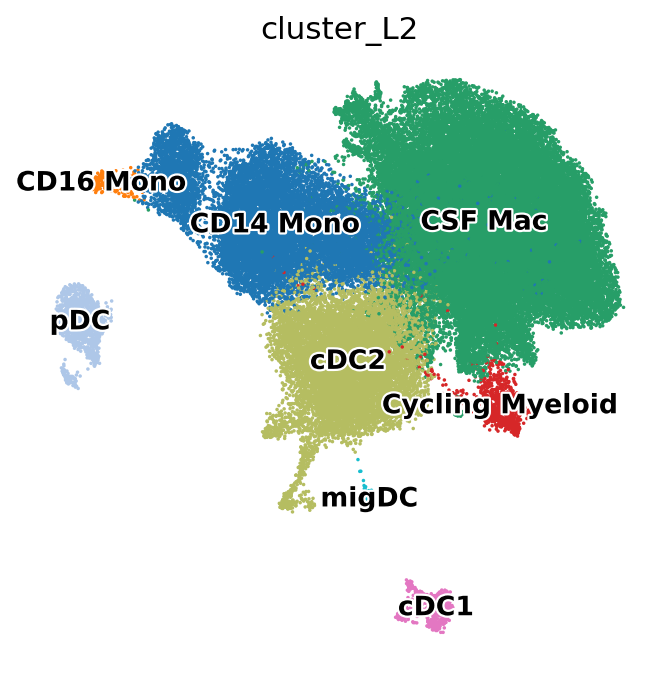

In [23]:
with mpl.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(
        adata,
        color="cluster_L2",
        # add_outline=True,
        legend_loc="on data",
        legend_fontsize=12,
        legend_fontoutline=2,
        size=10,
        frameon=False,
        save='cluster_L2.pdf'
    )

In [12]:
marker_genes = {
    "CD14 Mono": ["FCN1", "CD14"],
    "CD16 Mono": ["FCGR3A", "LYN"],
        "CSF Mac": ['C1QC', 'TREM2', 'APOE'],
            "Cycling Myeloid": ["MKI67", "CDK1"],
    # Note: DMXL2 should be negative
    "cDC1": ['XCR1'],
    "cDC2": ["CLEC10A", "FCER1A"],
    "migDC": ['CCR7', 'LAMP3'],
    "pDC": ["IRF8", "IL3RA"],

}

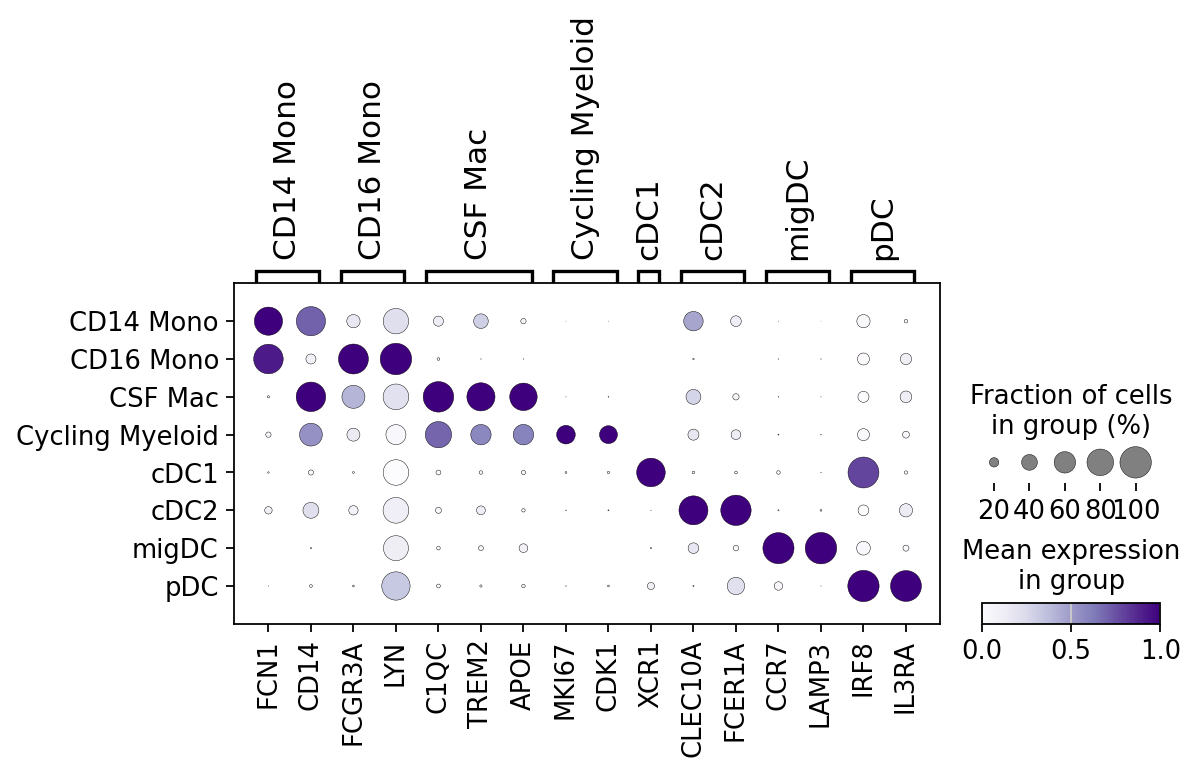

In [13]:
sc.pl.dotplot(adata, marker_genes, groupby="cluster_L2", standard_scale="var", cmap='Purples',
             save='final_annot_markergenes')

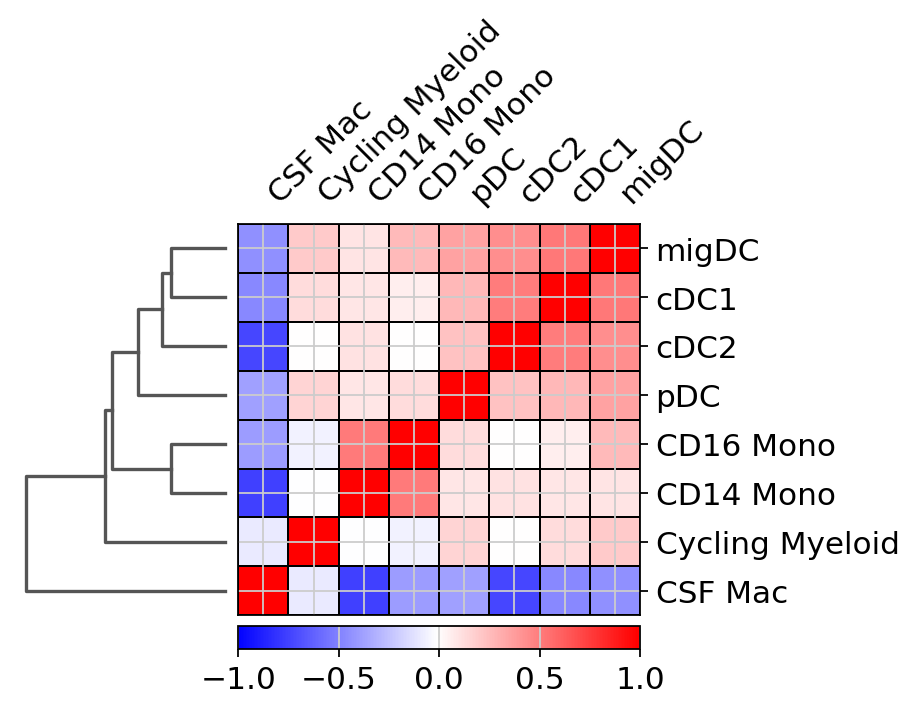

In [36]:
sc.pl.correlation_matrix(adata, "cluster_L2", figsize=(5, 3.5))

In [38]:
net = dc.get_collectri(organism='human', split_complexes=False)
net

  File "/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/omnipath/_core/downloader/_downloader.py", line 143, in maybe_download
    res = self._download(req)
          ^^^^^^^^^^^^^^^^^^^
  File "/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/omnipath/_core/downloader/_downloader.py", line 181, in _download
    resp.raise_for_status()
  File "/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 500 Server Error: Internal Server Error for url: https://omnipathdb.org/queries/enzsub?format=json

  File "/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/omnipath/_core/downloader/_downloader.py", line 143, in maybe_download
    res = self._download(req)
          ^^^^^^^^^^^^^^^^^^^
  File "/gpfs/gibbs/project/hafler

  0%|          | 0.00/2.43M [00:00<?, ?B/s]

0.00B [00:00, ?B/s]

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
42712,NFKB,hsa-miR-143-3p,1,19472311
42713,AP1,hsa-miR-206,1,19721712
42714,NFKB,hsa-miR-21-5p,1,20813833;22387281
42715,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [39]:
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

109 features of mat are empty, they will be removed.
Running ulm on mat with 61822 samples and 24046 targets for 690 sources.


  0%|          | 0/7 [00:00<?, ?it/s]

In [40]:
acts = dc.get_acts(adata, obsm_key='ulm_estimate')
acts

AnnData object with n_obs × n_vars = 61822 × 690
    obs: 'cellranger_sample_id', 'SampleID', 'SampleType', 'DonorID', 'Estimated Number of Cells', 'Mean Reads per Cell', 'Median Genes per Cell', 'Number of Reads', 'Valid Barcodes', 'Sequencing Saturation', 'Q30 Bases in Barcode', 'Q30 Bases in RNA Read', 'Q30 Bases in UMI', 'Reads Mapped to Genome', 'Reads Mapped Confidently to Genome', 'Reads Mapped Confidently to Intergenic Regions', 'Reads Mapped Confidently to Intronic Regions', 'Reads Mapped Confidently to Exonic Regions', 'Reads Mapped Confidently to Transcriptome', 'Reads Mapped Antisense to Gene', 'Fraction Reads in Cells', 'Total Genes Detected', 'Median UMI Counts per Cell', 'Q30 Bases in RNA Read 2', 'chemistry', 'Diagnosis', 'Gender', 'Age', 'Visit', 'SubjectID', 'DateICFSigned', 'YearICFSigned', 'EnrollmentCategory', 'RBDY/N?', 'YearofRBDDx', 'RBDAAO', 'AgeRBDDx', 'RBDDxtoConesnt', 'PDY/N', 'Year1stPDSx', 'YearofPDDx', 'PDAAO', 'AgePDDx', 'PDDxtoConsent', 'DLBY/N', 'Year1

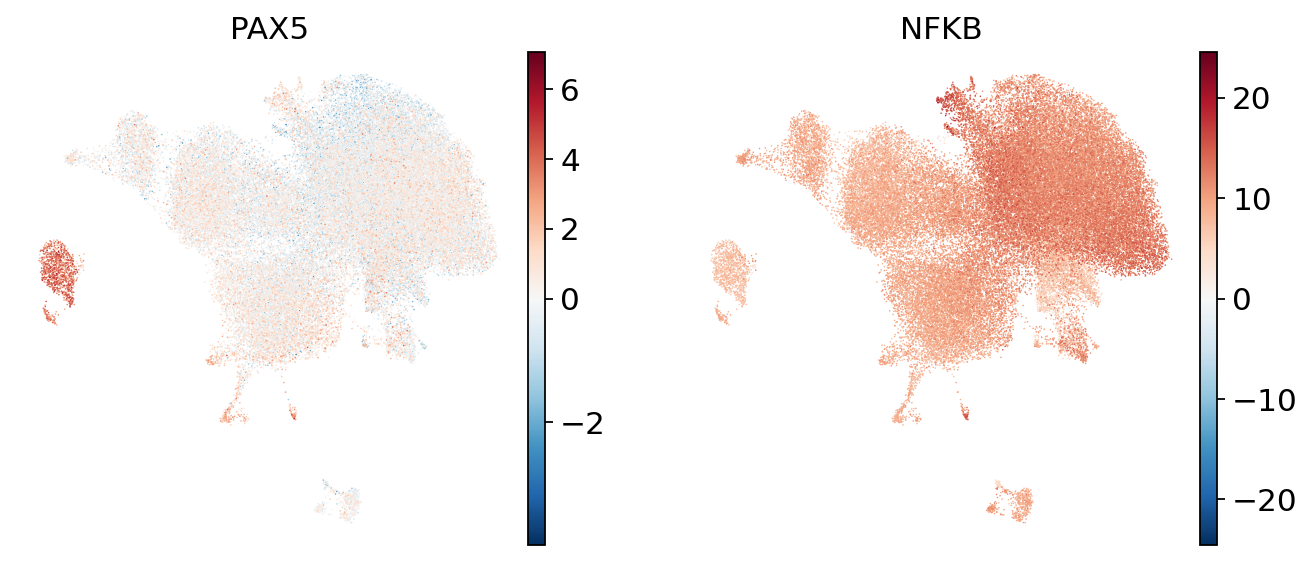

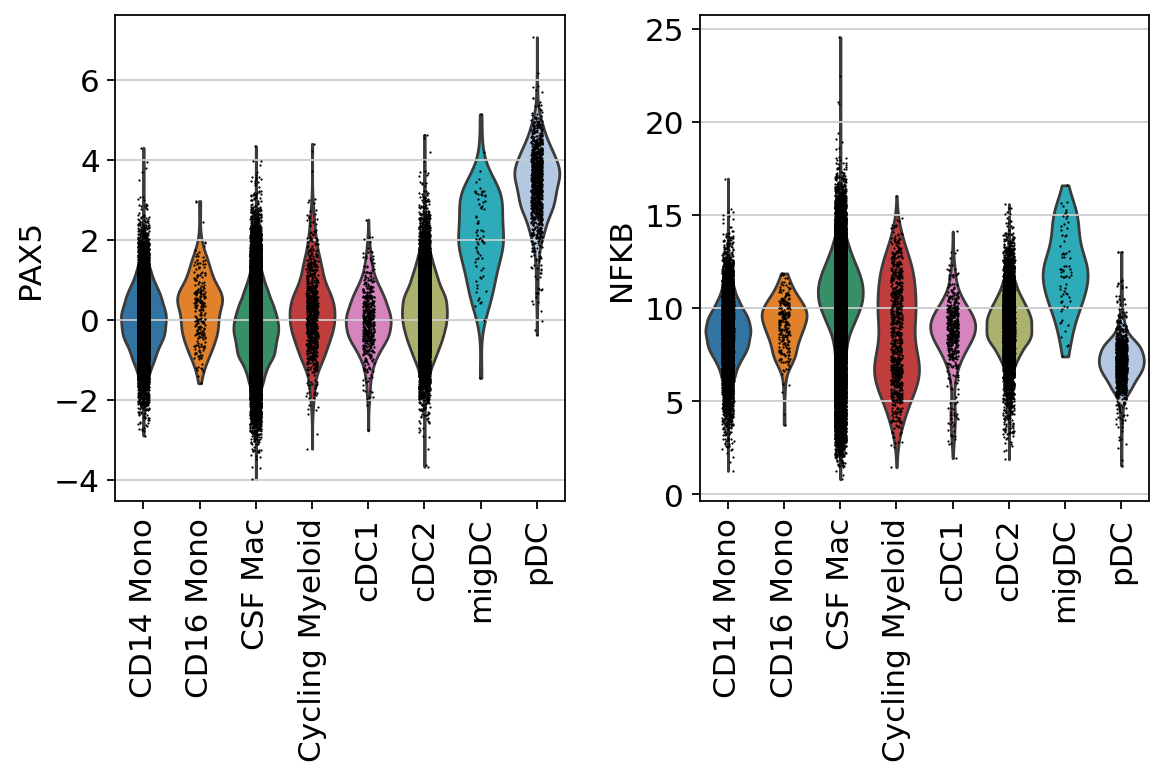

In [45]:
sc.pl.umap(acts, color=['PAX5', 'NFKB'], cmap='RdBu_r', vcenter=0)
sc.pl.violin(acts, keys=['PAX5', 'NFKB'], groupby='cluster_L2', rotation=90)

In [47]:
df = dc.rank_sources_groups(acts, groupby='cluster_L2', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,CD14 Mono,rest,ELF5,135.777377,1.900093,0.0,0.0
1,CD14 Mono,rest,CEBPE,114.783221,1.955879,0.0,0.0
2,CD14 Mono,rest,FOXQ1,110.850773,1.243347,0.0,0.0
3,CD14 Mono,rest,ZNF202,102.796197,1.767068,0.0,0.0
4,CD14 Mono,rest,ZNF335,92.192426,1.621958,0.0,0.0
...,...,...,...,...,...,...,...
5515,pDC,rest,EHF,-61.840541,-2.914901,0.0,0.0
5516,pDC,rest,ZIC2,-64.380337,-3.807919,0.0,0.0
5517,pDC,rest,HOXB1,-65.417392,-1.653867,0.0,0.0
5518,pDC,rest,ETV2,-65.745991,-2.838732,0.0,0.0


In [48]:
n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

{'CD14 Mono': ['ELF5', 'CEBPE', 'FOXQ1'],
 'CD16 Mono': ['NFX1', 'PAX6', 'BCL11B'],
 'CSF Mac': ['PITX3', 'ZIC2', 'BHLHA15'],
 'Cycling Myeloid': ['E2F4', 'E2F1', 'TFDP1'],
 'cDC1': ['MED1', 'CIITA', 'MEIS1'],
 'cDC2': ['RFX5', 'RFXAP', 'RFXANK'],
 'migDC': ['NOTCH1', 'TRERF1', 'HOXA10'],
 'pDC': ['FOXP1', 'PAX5', 'FOXI1']}

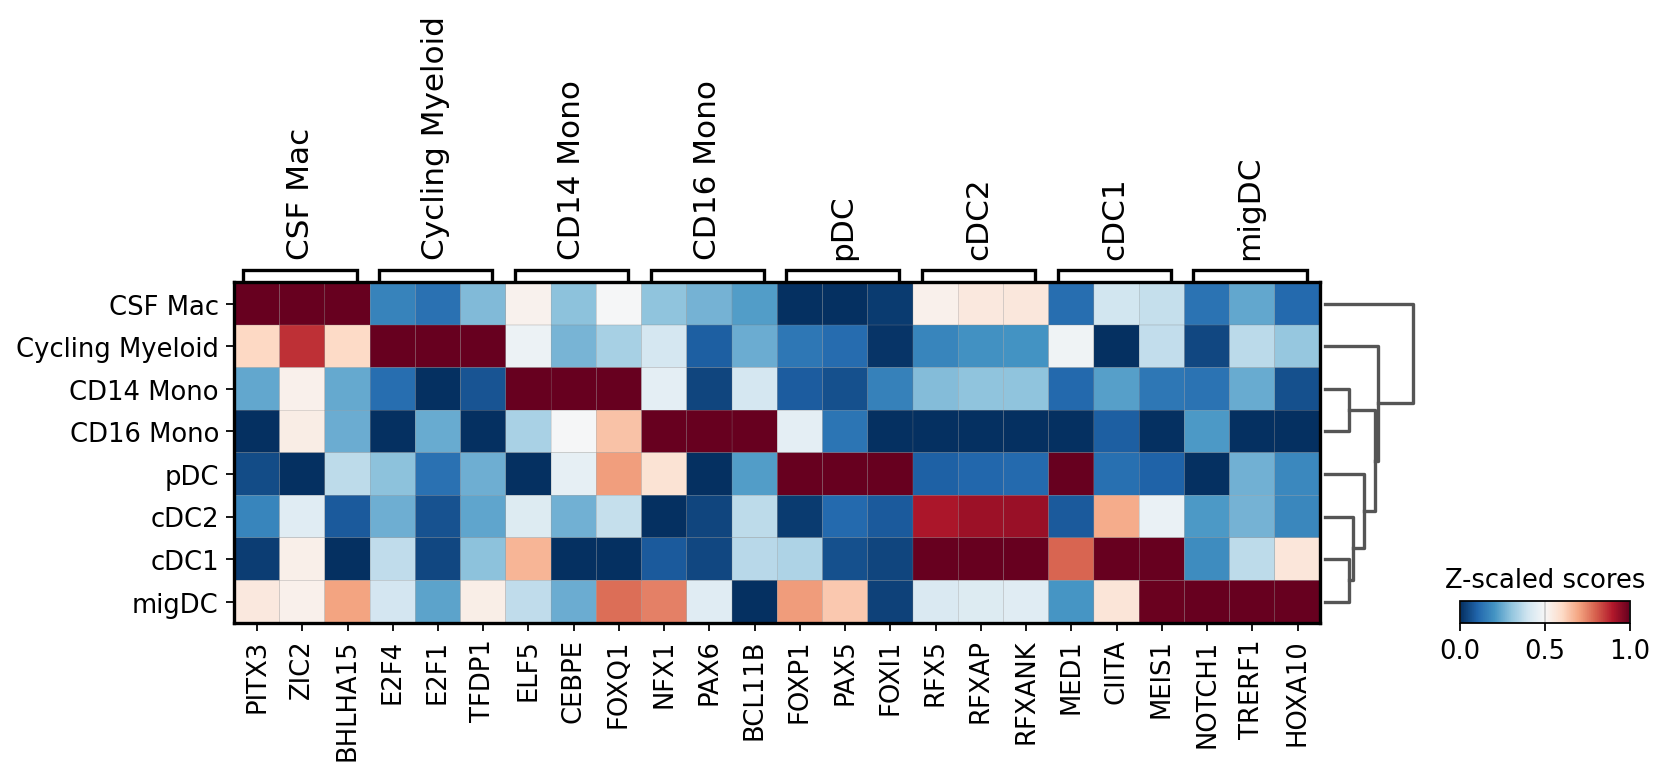

In [49]:
sc.pl.matrixplot(acts, source_markers, 'cluster_L2', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')